In [193]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

# Set seeds for reproducibility
seed = 123


In [194]:
# load full training set
df = pd.read_pickle(r"train_enc.pkl")

In [195]:
# Separate labels and target
X, y =  df.drop(columns="left", axis = 1), df["left"]
# Create train and validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

In [196]:
# Get variable names
bi_vars = [col for col in X.columns if X[col].nunique() == 2]
num_vars = [col for col in X.columns if (X[col].dtype in ["int8", "float32"]) & (col not in bi_vars)]
cat_vars = [col for col in X.columns if (col not in num_vars) & (col not in bi_vars)]

In [197]:
# Preprocessing recipe
preprocess = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_vars),
        ("ohe", OneHotEncoder(), cat_vars)
    ], remainder = 'passthrough'
)

In [198]:
# K-folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# Define metric
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)  

metric = make_scorer(f2_measure)

## Select model

>DM 0.673 (0.001)
>LGB 0.727 (0.028)
>CB 0.728 (0.026)
>XGB 0.724 (0.027)


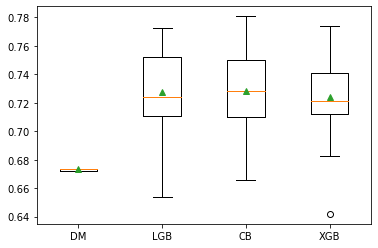

In [199]:

### Especify models ###
# LightGBM
lgbm_model = LGBMClassifier(random_seed=seed)
# Catboost
cb_model = CatBoostClassifier(random_seed=seed)
# XGBoost 
xgb_model = XGBClassifier(random_state=seed)

def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)  

metric = make_scorer(f2_measure)
# Evaluate a model
def evaluate_model(X, y, model):
    # Define the model evaluation metric
    metric = make_scorer(f2_measure)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores
    
# Define models to test
def get_models():
    models, names = list(), list()
    # DUMMY
    models.append(DummyClassifier(strategy='constant', constant=1, random_state=seed))
    names.append('DM')
    # LGB
    models.append(lgbm_model)
    names.append('LGB')
    # CB
    models.append(cb_model)
    names.append('CB')
    # XGB
    models.append(xgb_model)
    names.append('XGB')
    return models, names

# Define models
models, names = get_models()
results = list()
# Evaluate each model
for i in range(len(models)):
    # Wrap the model in a pipeline
    base_pipeline = Pipeline(steps=[
        ('recipe', preprocess),
        ('m',models[i])
    ])
    # Evaluate the model and store results
    scores = evaluate_model(X, y, base_pipeline) # <-- using training set for CV
    results.append(scores)
    # Summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    
# Plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [1]:
weights=2
### Especify models ###
# LightGBM
lgbm_model = LGBMClassifier(random_seed=seed,scale_pos_weight=weights)
# Catboost
cb_model = CatBoostClassifier(random_seed=seed,scale_pos_weight=weights)
# XGBoost 
xgb_model = XGBClassifier(random_state=seed,scale_pos_weight=weights)

def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)  

metric = make_scorer(f2_measure)
# Evaluate a model
def evaluate_model(X, y, model):
    # Define the model evaluation metric
    metric = make_scorer(f2_measure)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores
    
# Define models to test
def get_models():
    models, names = list(), list()
    # DUMMY
    models.append(DummyClassifier(strategy='constant', constant=1, random_state=seed))
    names.append('DM')
    # LGB
    models.append(lgbm_model)
    names.append('LGB')
    # CB
    models.append(cb_model)
    names.append('CB')
    # XGB
    models.append(xgb_model)
    names.append('XGB')
    return models, names

# Define models
models, names = get_models()
results = list()
# Evaluate each model
for i in range(len(models)):
    # Wrap the model in a pipeline
    base_pipeline = Pipeline(steps=[
        ('recipe',preprocess),
        ('m',models[i])
    ])
    # Evaluate the model and store results
    scores = evaluate_model(X, y, base_pipeline) # <-- using training set for CV
    results.append(scores)
    # Summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    
# Plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

NameError: name 'LGBMClassifier' is not defined

>TL 0.759 (0.026)
>ENN 0.811 (0.020)
>RENN 0.813 (0.016)
>SM 0.783 (0.023)
>BSM 0.790 (0.023)
>SVMSM 0.776 (0.027)
>SMTL 0.790 (0.021)
>SMTENN 0.818 (0.014)


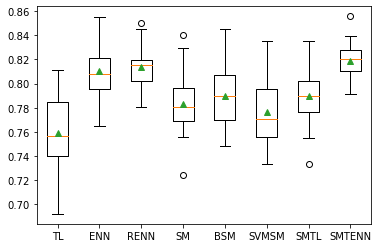

In [222]:
# Under
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# Over
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
# Under + Over (smote)
from imblearn.combine import SMOTETomek 
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

lgbm_model = LGBMClassifier(random_seed=seed)

def get_models_und():
    models_und, names = list(), list()
    # TL
    models_und.append(TomekLinks())
    names.append('TL')
    # ENN
    models_und.append(EditedNearestNeighbours())
    names.append('ENN')
    # RENN
    models_und.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    # SM
    models_und.append(SMOTE())
    names.append('SM')
    # BSM
    models_und.append(BorderlineSMOTE())
    names.append('BSM')
    # SVMSM
    models_und.append(SVMSMOTE())
    names.append('SVMSM')
    # SMOTETomek
    models_und.append(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'),random_state=seed))
    names.append('SMTL')
    # SMOTEENN
    models_und.append(SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),random_state=seed))
    names.append('SMTENN')
    return models_und, names

# Define models
u_models, u_names = get_models_und()
under_results = list()
# Evaluate each model
for i in range(len(u_models)):
    # Wrap the model in a pipeline
    under_pipeline = Pipeline(steps=[
        ('recipe',preprocess),
        ('s',u_models[i]),
        ("m", lgbm_model)
    ])
    # Evaluate the model and store results
    under_scores = evaluate_model(X, y, under_pipeline) # <-- using training set for CV
    under_results.append(under_scores)
    # Summarize and store
    print('>%s %.3f (%.3f)' % (u_names[i], np.mean(under_scores), np.std(under_scores)))
# Plot the results
plt.boxplot(under_results, labels=u_names, showmeans=True)
plt.show()

In [ ]:
g=sns.pairplot(vars=[col for col in X if col!='clusters'], data=X, hue='clusters')
g.fig.set_size_inches(10,8)
plt.show()

In [275]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
smoteen = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),random_state=seed)

renn = RepeatedEditedNearestNeighbours()
model_lgbm_2 = LGBMClassifier(random_seed=seed,scale_pos_weight=1, num_leaves=63, learning_rate=0.170203379715839,min_child_samples=52,
min_child_weight=0.006613995003545587, subsample=0.47484181362301797,colsample_bytree=0.9925491750965401,reg_alpha=6.458111463493501)

final_pipeline = make_pipeline(preprocess,smoteen, model_lgbm_2)
final_pipeline.fit(X_train, y_train)
    # Obtain the predictions from our random forest model 
predicted = final_pipeline.predict(X_val)
    # Predict probabilities
probs = final_pipeline.predict_proba(X_val)
    # Print the ROC curve, classification report and confusion matrix
#print(roc_auc_score(y_val, probs[:,1]))
print(classification_report(y_val, predicted))
print(confusion_matrix(y_val, predicted))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1351
           1       0.57      0.90      0.70       557

    accuracy                           0.78      1908
   macro avg       0.76      0.81      0.76      1908
weighted avg       0.84      0.78      0.79      1908

[[978 373]
 [ 55 502]]


In [257]:
test = pd.read_pickle(r"test_enc.pkl")
X_test, y_test = test.drop("left", axis = 1), test["left"]

final_pipeline = make_pipeline(preprocess,renn, model_lgbm_2)
final_pipeline.fit(X, y)
    # Obtain the predictions from our random forest model 
predicted = final_pipeline.predict(X_test)
    # Predict probabilities
probs = final_pipeline.predict_proba(X_test)
    # Print the ROC curve, classification report and confusion matrix
#print(roc_auc_score(y_val, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1351
           1       0.58      0.93      0.72       557

    accuracy                           0.79      1908
   macro avg       0.77      0.83      0.77      1908
weighted avg       0.85      0.79      0.80      1908

[[983 368]
 [ 39 518]]


In [256]:
preds = final_pipeline.predict_proba(X_test)

# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ["prob_churn"])

# Reassign loan status based on the threshold
preds_df['churn_status'] = preds_df['prob_churn'].apply(lambda x: 1 if x > 0.24 else 0)

preds_df['real_status'] = pd.DataFrame(y_val.values)
# Print the row counts for each loan status
num_churns = preds_df['churn_status'].value_counts()[1]

# Print the classification report
target_names = ['Non-churn', 'Churn']
print(classification_report(y_test, preds_df['churn_status'], target_names=target_names))
print(confusion_matrix(y_test, preds_df['churn_status']))

              precision    recall  f1-score   support

   Non-churn       0.98      0.61      0.75      1351
       Churn       0.51      0.97      0.67       557

    accuracy                           0.72      1908
   macro avg       0.74      0.79      0.71      1908
weighted avg       0.84      0.72      0.73      1908

[[827 524]
 [ 18 539]]


In [204]:
df["left"].value_counts()

0    5405
1    2227
Name: left, dtype: int64

In [215]:
df["left"].value_counts()[0] 

5405

In [219]:
weights =round(np.sqrt(df["left"].value_counts()[0] / df["left"].value_counts()[1]),2)
weights

1.56

In [286]:
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline, Pipeline


model_lgbm_final = LGBMClassifier(random_seed=seed,scale_pos_weight=2, num_leaves=63, learning_rate=0.170203379715839,min_child_samples=52,
min_child_weight=0.006613995003545587, subsample=0.47484181362301797,colsample_bytree=0.9925491750965401,reg_alpha=6.458111463493501 )

final_pipeline = make_pipeline(preprocess,smoteen, model_lgbm_final)

In [287]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

final_pipeline.fit(X_train, y_train)
    # Obtain the predictions from our random forest model 
predicted = final_pipeline.predict(X_val)
    # Predict probabilities
probs = final_pipeline.predict_proba(X_val)
    # Print the ROC curve, classification report and confusion matrix
#print(roc_auc_score(y_val, probs[:,1]))
print(classification_report(y_val, predicted))
print(confusion_matrix(y_val, predicted))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1351
           1       0.53      0.92      0.68       557

    accuracy                           0.74      1908
   macro avg       0.75      0.80      0.73      1908
weighted avg       0.83      0.74      0.75      1908

[[903 448]
 [ 42 515]]


In [288]:
conf_mat = confusion_matrix(y_val, predicted)
tn, fp, fn, tp = conf_mat.ravel()
(fp, fn)

(448, 42)

### Loss functions

Remember that we are focusing on minimizing the false negatives, because the cost of false positives are much higher than for false positives. But
how much? 2x?3x?

FP: The manager informed that the company losses 2x the avarage salary for each churned employee. 
    - We will assume that fn costs 2x more than fp.
FN: Investing in emplooyees that did not leave the company is not a loss.



In [63]:
# Get labels from the scores using the default threshold
preds = [s[1] > 0.5 for s in probs]

# Use the predict method to label the test data again
preds_churn = predicted

# Compare the two sets of predictions
all(preds == preds_churn)

True

Well done, you have confirmed that this classifier, too, uses 0.5 as a threshold

In [281]:
from sklearn.metrics import recall_score, f1_score

# Create a range of equally spaced threshold values
t_range = [0.0, 0.25, 0.5, 0.75, 1.0]

# Store the predicted labels for each value of the threshold
preds = [[s[1] > thr for s in probs] for thr in t_range]

# Compute the accuracy for each threshold
recall_scores = [recall_score(y_val, p) for p in preds]

# Compute the F1 score for each threshold
f1_scores = [f1_score(y_val, p) for p in preds]

# Report the optimal threshold for accuracy, and for F1
print(t_range[np.argmax(recall_scores)], t_range[np.argmax(f1_scores)])

0.0 0.75


The choice of threshold will have an impact in the trade-offs of positive and negative errors. The simple way to handle class imbalance is to change the decision threshold.

So how to do it?

1. fit model on the training set
2. predict probabilities on test set
3. for each threshold:
    Convert probabilities to Class Labels using the threshold
    evaluate class labels
    if score is better than best score
        - use it
4. Use the threshold 



### The precision-recall curve

<function matplotlib.pyplot.show(close=None, block=None)>

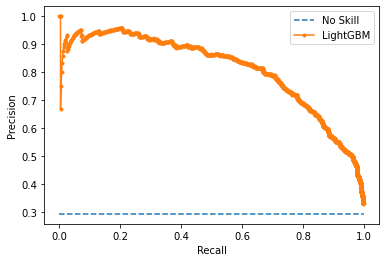

In [289]:
from sklearn.metrics import precision_recall_curve
# keep probabilities for positive class
yhat =final_pipeline.predict_proba(X_val)[:,1]

precision, recall, thresholds = precision_recall_curve(y_val, yhat)

no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show

In [290]:
# convert to f2-measure
f2score = (5 * precision * recall) / (4 * precision + recall)
ix = np.argmax(f2score)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], f2score[ix]))

Best Threshold=0.294404, F-measure=0.812


<function matplotlib.pyplot.show(close=None, block=None)>

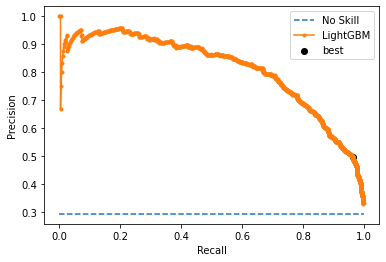

In [291]:
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.scatter(recall[ix], precision[ix], marker="o", color="black", label="best")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show

In [292]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
# define thresholds
thresholds = np.arange(0, 1, 0.001)

scores = [fbeta_score(y_val, to_labels(yhat, t),beta=2) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-measure=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.350, F-measure=0.81200


## Results with other thresholds

In [295]:
preds = final_pipeline.predict_proba(X_val)

# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ["prob_churn"])


# Reassign loan status based on the threshold
preds_df['churn_status'] = preds_df['prob_churn'].apply(lambda x: 1 if x > 0.35 else 0)

preds_df['real_status'] = pd.DataFrame(y_val.values)
# Print the row counts for each loan status
num_churns = preds_df['churn_status'].value_counts()[1]

# Print the classification report
target_names = ['Non-churn', 'Churn']
print(classification_report(y_val, preds_df['churn_status'], target_names=target_names))
print(confusion_matrix(y_val, predicted))

              precision    recall  f1-score   support

   Non-churn       0.97      0.61      0.75      1351
       Churn       0.51      0.96      0.66       557

    accuracy                           0.71      1908
   macro avg       0.74      0.79      0.71      1908
weighted avg       0.84      0.71      0.73      1908

[[903 448]
 [ 42 515]]


In [249]:
# COST FUNCTION
def my_scorer(y_test, y_est, cost_fp=1, cost_fn=2):
    tn, fp, fn, tp = confusion_matrix(y_test, y_est).ravel()
    return cost_fp*fp + cost_fn*fn

clf = final_pipeline.fit(X_train, y_train)
print(my_scorer(y_val, clf.predict(X_val)))

525


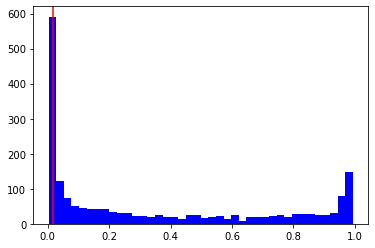

In [166]:
# Create a dataframe for the probabilities of default
preds_df_cal = preds[:,1]
preds_df_cal
plt.hist(preds_df_cal, color="blue", bins=40)
# Calculate the threshold with quantile
threshold_q = np.quantile(preds_df_cal, 0.85) # acceptance rate of 85% using 

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold_q, color = 'red')
plt.show()

left side are accepted churns, right are churns rejected

In [ ]:
target_names = ['Non-churn', 'Churn']
print(classification_report(y_val, preds_df['churn_status'], target_names=target_names))

In [296]:
# Print the top 5 rows of the new data frame
print(preds_df.head())

# Create a subset of only accepted loans
accepted_loans = preds_df[preds_df['churn_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['real_status']) / accepted_loans['real_status'].count())

   prob_churn  churn_status  real_status
0    0.997551             1            1
1    0.026225             0            0
2    0.993682             1            0
3    0.997360             1            1
4    0.011213             0            0
0.02810304449648712


In [298]:
import plotly.express as px
fig = px.histogram(preds_df, x="prob_churn")
fig.show()

In [299]:
threshold_q = np.quantile(preds_df.prob_churn, 0.85)
threshold_q

0.9930050596040154

In [148]:
preds_df

,prob_churn,churn_status
0,0.975084,1
1,0.007028,0
2,0.954381,1
3,0.984179,1
4,0.006276,0
...,...,...
1903,0.007506,0
1904,0.016795,0
1905,0.619813,1
1906,0.128582,0


In [ ]:
# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_churns * avg_loan_amnt * (1 - default_recall))

In [129]:
probs1 = (final_pipeline.predict_proba(X_val)[:,1]>=0.24).astype(int)
probs1

array([1, 0, 1, ..., 1, 0, 0])

In [276]:
# Create a scorer assigning more cost to false positives
def my_scorer(y_test, y_est, cost_fp=1, cost_fn=2):
    tn, fp, fn, tp = confusion_matrix(y_test, y_est).ravel()
    return cost_fp*fp + cost_fn*fn

clf = final_pipeline.fit(X_train, y_train)
print(my_scorer(y_val, clf.predict(X_val)))

483
